# Create and clean the basic Dataframe

In [1]:
RANDOM_SEED = 42

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df_pre = pd.read_csv('files/fraud.csv')
df_pre.shape

(26975, 16)

In [4]:
#exp
df_pre.head()

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude
0,0,F,608.345634,2020-01-21,20,"{'model': 2020, 'device_score': 3, 'os': 'ANDR...",Super,Merida,Física,71000,51,Aceptada,False,60.834563,5.475111,False
1,0,F,88.719243,2020-01-15,7,"{'model': 2020, 'device_score': 1, 'os': 'ANDR...",NaN,Merida,Virtual,71000,51,Aceptada,False,0.000000,1.774385,False
2,1,F,790.037653,2020-01-17,11,"{'model': 2020, 'device_score': 1, 'os': '.'}",NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False
3,1,F,767.005387,2020-01-05,11,"{'model': 2020, 'device_score': 3, 'os': 'WEB'}",MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,7.670054,False
4,1,F,254.171053,2020-01-30,10,"{'model': 2020, 'device_score': 3, 'os': '%%'}",NaN,Guadalajara,Física,94000,56,Aceptada,False,0.000000,2.541711,False


In [5]:
df_pre['fecha_hora'] = pd.to_datetime(df_pre.fecha) + df_pre.hora.astype('timedelta64[h]')

In [6]:
df_pre.rename(columns={'ID_USER':'id', 'dcto':'descuento'}, inplace=True)

In [7]:
df_pre['unix_time'] = df_pre['fecha_hora'].astype(np.int64) / 10**9

In [8]:
df_pre = df_pre.sort_values(by=['id', 'fecha_hora']).reset_index(drop=True)

In [9]:
df_pre.fraude = df_pre['fraude'].astype(int)

In [10]:
current_id = 0
fraude_sum_list = []
current_sum = 0

for index, row in df_pre.iterrows():
    if current_id == row.id:
        current_sum = current_sum + row.fraude
        fraude_sum_list.append(current_sum)
        
    else:
        current_id = row.id
        current_sum = row.fraude
        fraude_sum_list.append(current_sum)


In [11]:
df_pre['fraudes_acumulados'] = fraude_sum_list

In [12]:
df_pre.fillna(value='nan', inplace=True)

In [13]:
import ast

df_pre['device_score'] = df_pre.dispositivo.apply(lambda x: ast.literal_eval(x).get('device_score'))
df_pre['os'] = df_pre.dispositivo.apply(lambda x: ast.literal_eval(x).get('os'))

In [14]:
df_pre.drop(columns='dispositivo', inplace=True)

In [15]:
df_pre_prepared = df_pre.drop(columns=['fraudes_acumulados', 'fecha', 'fecha_hora'])

In [16]:
df_pre_prepared

,id,genero,monto,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,descuento,cashback,fraude,unix_time,device_score,os
0,0,F,88.719243,7,nan,Merida,Virtual,71000,51,Aceptada,False,0.000000,1.774385,0,1.579072e+09,1,ANDROID
1,0,F,608.345634,20,Super,Merida,Física,71000,51,Aceptada,False,60.834563,5.475111,0,1.579637e+09,3,ANDROID
2,1,F,767.005387,11,MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,7.670054,0,1.578222e+09,3,WEB
3,1,F,334.516017,2,Abarrotes,Guadalajara,Física,94000,56,Aceptada,False,33.451602,3.010644,0,1.578276e+09,1,%%
4,1,F,322.264405,13,MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,3.222644,0,1.578748e+09,4,%%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26970,3999,M,517.209272,20,MPago,Toluca,Física,40000,56,En proceso,False,0.000000,5.172093,0,1.578082e+09,5,ANDROID
26971,3999,M,746.192089,13,nan,Toluca,Física,40000,56,Aceptada,False,0.000000,7.461921,0,1.578488e+09,2,ANDROID
26972,3999,M,24.182665,17,nan,Toluca,Física,40000,56,Aceptada,False,2.418266,0.217644,0,1.578935e+09,5,.
26973,3999,M,941.804966,15,nan,Toluca,Física,40000,56,Aceptada,False,0.000000,9.418050,0,1.579014e+09,2,WEB


# Pipelines for data preparation

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer  
from sklearn.compose import make_column_selector   

ohe = OneHotEncoder(drop='first')

ct = make_column_transformer((ohe, make_column_selector(dtype_include=[object, bool])), remainder='passthrough')

# Create Train and Test Sets

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
def make_test_set(df_var):
    train, test = train_test_split(df_var, test_size=0.25, random_state=RANDOM_SEED, stratify=df_var.fraude)
    
    return train, test

In [23]:
def split_df_into_matrices(df_var):
    
    X = df_var.drop(columns='fraude')
    y = df_var['fraude'].copy()
    
    return X, y

In [24]:
train_set_pre, test_set_pre = make_test_set(df_pre_prepared)

In [25]:
X_train_pre, y_train_pre = split_df_into_matrices(train_set_pre)

In [26]:
X_test_pre, y_test_pre = split_df_into_matrices(test_set_pre)

# Feature Selection

In [29]:
X_train_selection = ct.fit_transform(X_train_pre)

In [30]:
y_train_selection = y_train_pre.reset_index(drop=True)

In [31]:
X_train_selection = pd.DataFrame(X_train_selection)

In [32]:
X_train_selection.columns = ct.get_feature_names()

In [33]:
X_train_selection

,onehotencoder__x0_F,onehotencoder__x0_M,onehotencoder__x1_Farmacia,onehotencoder__x1_MPago,onehotencoder__x1_Restaurante,onehotencoder__x1_Super,onehotencoder__x1_nan,onehotencoder__x2_Merida,onehotencoder__x2_Monterrey,onehotencoder__x2_Toluca,...,onehotencoder__x6_WEB,id,monto,hora,linea_tc,interes_tc,descuento,cashback,unix_time,device_score
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2651.0,332.871468,2.0,80000.0,36.0,0.000000,3.328715,1.580177e+09,4.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2594.0,477.607896,9.0,77000.0,36.0,0.000000,4.776079,1.578733e+09,4.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,3961.0,45.657438,1.0,55000.0,51.0,0.000000,0.456574,1.579050e+09,5.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,284.0,396.121359,5.0,99000.0,58.0,0.000000,3.961214,1.578200e+09,2.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,414.0,192.753247,21.0,99000.0,55.0,0.000000,3.855065,1.579295e+09,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20226,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,2697.0,174.575747,18.0,94000.0,52.0,0.000000,1.745757,1.580062e+09,1.0
20227,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3045.0,633.006746,15.0,86000.0,59.0,0.000000,6.330067,1.578755e+09,5.0
20228,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,3260.0,120.039168,23.0,30000.0,63.0,12.003917,1.080353,1.579907e+09,3.0
20229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,2937.0,779.422653,5.0,40000.0,50.0,0.000000,15.588453,1.579583e+09,5.0


In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [35]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train_selection, y_train_selection)

In [36]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train_selection.columns)


featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['column','Score'] 
featureScores.sort_values(by='Score', ascending=False).reset_index(drop=True).head(11)

,column,Score
0,id,1842.068226
1,unix_time,258.587214
2,linea_tc,82.231721
3,monto,41.005834
4,hora,15.794044
5,descuento,4.628610
6,onehotencoder__x1_MPago,1.418351
7,onehotencoder__x2_Merida,1.144656
8,onehotencoder__x6_WEB,0.987082
9,onehotencoder__x1_Restaurante,0.835686


In [37]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_train_selection, y_train_selection)

feat_importances = pd.Series(model.feature_importances_, index=X_train_selection.columns)

In [38]:
feat_importances.sort_values(ascending=False)[0:11]

cashback                     0.087221
unix_time                    0.087126
id                           0.086287
monto                        0.085869
linea_tc                     0.084385
interes_tc                   0.083676
hora                         0.082480
device_score                 0.062167
descuento                    0.052319
onehotencoder__x3_Virtual    0.022620
onehotencoder__x6_.          0.021040
dtype: float64

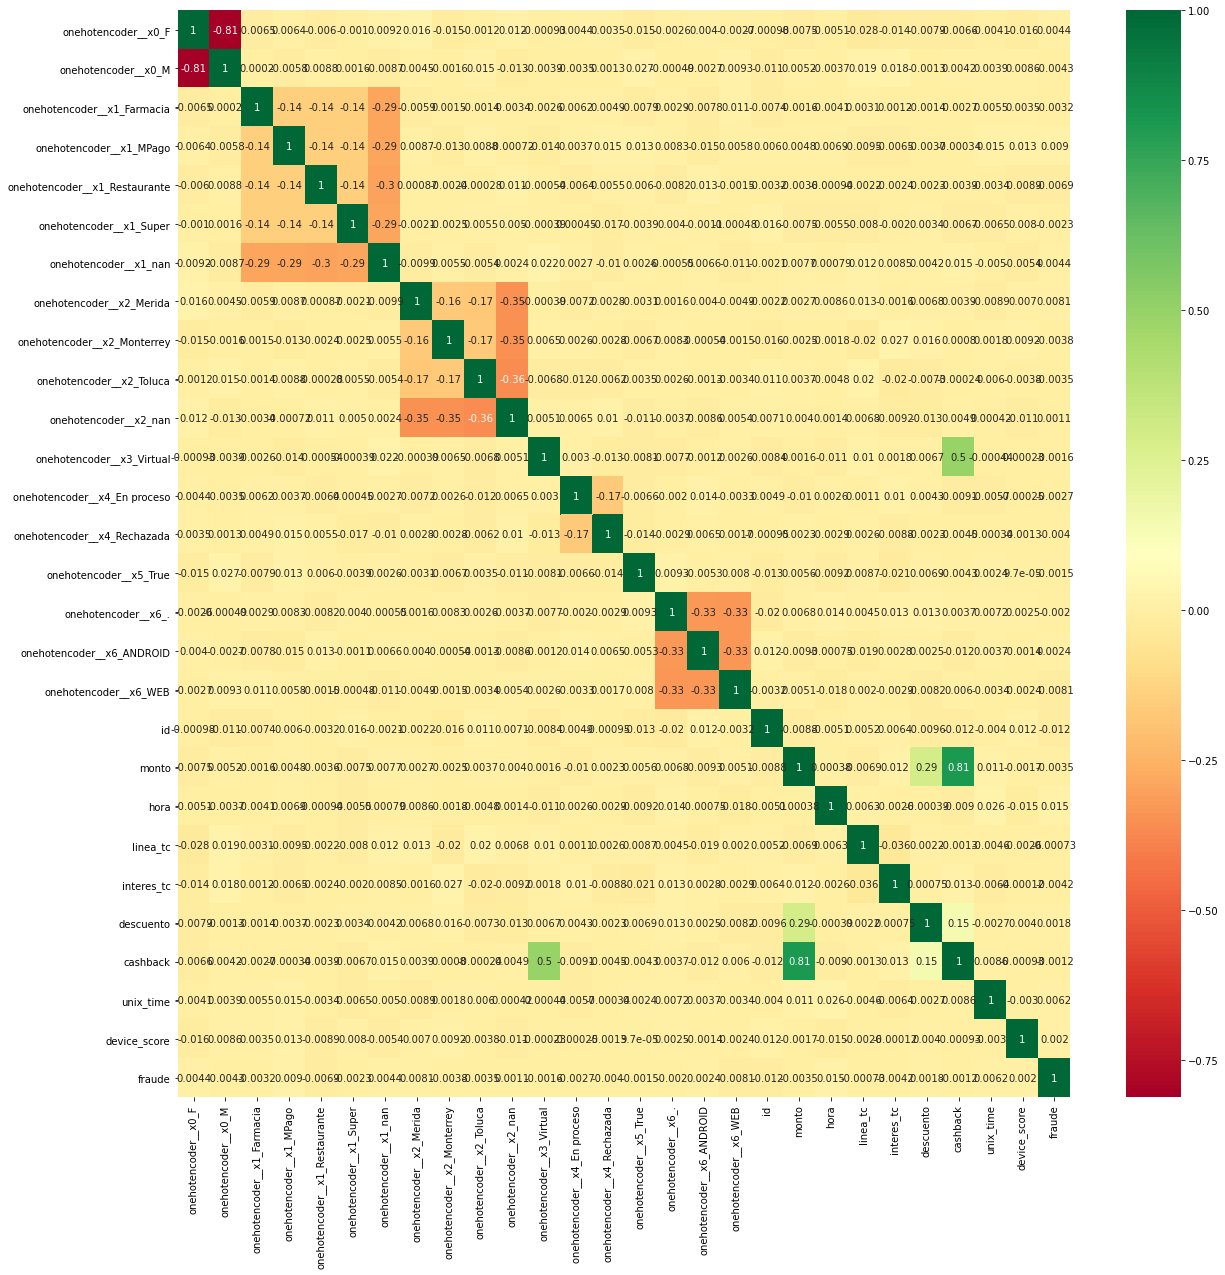

In [39]:
import seaborn as sns

X_train_selection['fraude'] = y_train_selection
corrmat = X_train_selection.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

g=sns.heatmap(X_train_selection[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = RANDOM_SEED)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
X_train_selection

In [83]:
train_set = X_train_selection[['id', 'unix_time', 'linea_tc', 'monto', 'hora', 'descuento', 'fraude']]

X_train = X_train_selection[['id', 'unix_time', 'linea_tc', 'monto', 'hora', 'descuento']]
y_train = X_train_selection['fraude']

X_test = X_test_pre[['id', 'unix_time', 'linea_tc', 'monto', 'hora', 'descuento']]
y_test = y_test_pre

In [140]:
X_test

,id,unix_time,linea_tc,monto,hora,descuento
23067,3425,1.578928e+09,27000,220.436952,15,0.000000
4971,759,1.578215e+09,87000,515.551317,9,51.555132
12277,1829,1.579104e+09,74000,529.111615,16,0.000000
5003,762,1.578539e+09,46000,770.718376,3,77.071838
16468,2415,1.578722e+09,81000,63.951347,6,0.000000
...,...,...,...,...,...,...
10420,1554,1.578658e+09,51000,608.382837,12,0.000000
11649,1740,1.579612e+09,91000,113.442370,13,0.000000
24056,3568,1.578604e+09,95000,854.525376,21,0.000000
4782,732,1.578510e+09,86000,889.827536,19,0.000000


# Mitigating Skewdness of Data, Pipelines

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

class UnderSamplingPipeline(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs  
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, df_var, y=None):
        class_0_count, class_1_count = df_var.fraude.value_counts()

        tmp_0 = df_var[df_var.fraude == 0]
        tmp_1 = df_var[df_var.fraude == 1]

        under_sampled_0_df = tmp_0.sample(class_1_count)
        under_sampled_df = pd.concat([under_sampled_0_df, tmp_1], axis=0)

        return under_sampled_df.sample(frac=1).reset_index(drop=True)


In [54]:
undersampling = UnderSamplingPipeline()
train_under = undersampling.transform(train_set)

In [55]:
train_under.shape, train_under.fraude.value_counts()

((1214, 7),
 0    607
 1    607
 Name: fraude, dtype: int64)

In [56]:
X_train_under, y_train_under = split_df_into_matrices(train_under)

In [57]:
X_train_under.shape, y_train_under.shape

((1214, 6), (1214,))

In [58]:
class OverSamplingPipeline(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs  
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, df_var, y=None):
        class_0_count, class_1_count = df_var.fraude.value_counts()

        tmp_0 = df_var[df_var.fraude == 0]
        tmp_1 = df_var[df_var.fraude == 1]

        over_sampled_1_df = tmp_1.sample(class_0_count, replace=True)
        over_sampled_df = pd.concat([over_sampled_1_df, tmp_0], axis=0)
        over_sampled_df = over_sampled_df.sample(frac=1).reset_index(drop=True)
        return over_sampled_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

In [59]:
oversampling = OverSamplingPipeline()
train_over = oversampling.transform(train_set)

In [60]:
train_over.shape, train_over.fraude.value_counts()

((39248, 7),
 0    19624
 1    19624
 Name: fraude, dtype: int64)

In [61]:
X_train_over, y_train_over = split_df_into_matrices(train_over)

In [62]:
X_train_over.shape, y_train_over.shape

((39248, 6), (39248,))

In [68]:
from imblearn.over_sampling import SMOTE 

class SMOTESamplingPipeline(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs  
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, df_var, y=None):
        X, y = split_df_into_matrices(df_var)
        
        sm = SMOTE(random_state=RANDOM_SEED)
        X_res, y_res = sm.fit_resample(X, y)

        X_res['fraude'] = y_res

        return X_res

In [69]:
smotesampling = SMOTESamplingPipeline()
train_smote = smotesampling.transform(train_set)

In [70]:
train_smote.shape, train_smote.fraude.value_counts()

((39248, 7),
 0    19624
 1    19624
 Name: fraude, dtype: int64)

In [71]:
X_train_smote, y_train_smote = split_df_into_matrices(train_smote)

In [72]:
X_train_smote.shape, y_train_smote.shape

((39248, 6), (39248,))

# Classification Metrics

In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# print(classification_report(y_test, y_pred, target_names = iris.target_names))
#     print('\nClassification Report\n')
    
def metrics(y_true, y_pred):
    print('\nAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred)))
    cm = confusion_matrix(y_true, y_pred)
    print(cm)


# Prepare the data

In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


X_train_over_prepared = scaler.fit_transform(X_train_over)
X_test_over_prepared = scaler.transform(X_test)

X_train_smote_prepared = scaler.fit_transform(X_train_smote)
X_test_smote_prepared = scaler.transform(X_test)


X_train_under_prepared = scaler.fit_transform(X_train_under)
X_test_under_prepared = scaler.transform(X_test)


X_train_prepared = scaler.fit_transform(X_train)
X_test_prepared = scaler.transform(X_test)

# Shortlisting Models

In [74]:
from sklearn.ensemble import RandomForestClassifier
forest_clf_100 = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
forest_clf_50 = RandomForestClassifier(n_estimators=50, random_state=RANDOM_SEED)

In [118]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf_5 = KNeighborsClassifier(n_neighbors = 5)
knn_clf_3 = KNeighborsClassifier(n_neighbors = 2)

In [99]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=RANDOM_SEED)

In [93]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
svm_linear_clf = LinearSVC(loss="hinge", random_state=42)
svc_poly_clf = SVC(kernel="poly", degree=6)
svc_rbf_clf = SVC(kernel="rbf")

In [103]:
from sklearn.neural_network import MLPClassifier
mlp_clf_lbfgs = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(25, 15, 2), random_state=RANDOM_SEED, max_iter=1000)
mlp_clf_adam = MLPClassifier(solver='adam',hidden_layer_sizes=(10, 10, 5), random_state=RANDOM_SEED, max_iter=1000)

## RandomForestClassifier

In [89]:
forest_clf_100.fit(X_train_prepared, y_train)
forest_clf_50.fit(X_train_prepared, y_train)

y_pred_forest_clf_100 = forest_clf_100.predict(X_test_prepared)
y_pred_forest_clf_50 = forest_clf_50.predict(X_test_prepared)

metrics(y_test, y_pred_forest_clf_100)
metrics(y_test, y_pred_forest_clf_50)


Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[6541    0]
 [ 203    0]]

Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[6541    0]
 [ 203    0]]


C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
forest_clf_100.fit(X_train_over_prepared, y_train_over)
forest_clf_50.fit(X_train_over_prepared, y_train_over)

y_pred_forest_clf_100 = forest_clf_100.predict(X_test_prepared)
y_pred_forest_clf_50 = forest_clf_50.predict(X_test_prepared)

metrics(y_test, y_pred_forest_clf_100)
metrics(y_test, y_pred_forest_clf_50)


Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[6539    2]
 [ 203    0]]

Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[6539    2]
 [ 203    0]]


In [91]:
forest_clf_100.fit(X_train_smote_prepared, y_train_smote)
forest_clf_50.fit(X_train_smote_prepared, y_train_smote)

y_pred_forest_clf_100 = forest_clf_100.predict(X_test_prepared)
y_pred_forest_clf_50 = forest_clf_50.predict(X_test_prepared)

metrics(y_test, y_pred_forest_clf_100)
metrics(y_test, y_pred_forest_clf_50)


Accuracy: 0.24
Precision: 0.03
Recall: 0.79
F1-score: 0.06

[[1477 5064]
 [  42  161]]

Accuracy: 0.25
Precision: 0.03
Recall: 0.80
F1-score: 0.06

[[1498 5043]
 [  41  162]]


## SVM

In [94]:
svm_linear_clf.fit(X_train_prepared, y_train)
svc_poly_clf.fit(X_train_prepared, y_train)
svc_rbf_clf.fit(X_train_prepared, y_train)

y_pred_svm_linear_clf = svm_linear_clf.predict(X_test_prepared)
y_pred_svc_poly_clf = svc_poly_clf.predict(X_test_prepared)
y_pred_svc_rbf_clf = svc_rbf_clf.predict(X_test_prepared)

metrics(y_test, y_pred_svm_linear_clf)
metrics(y_test, y_pred_svc_poly_clf)
metrics(y_test, y_pred_svc_rbf_clf)


Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[6541    0]
 [ 203    0]]

Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[6540    1]
 [ 203    0]]

Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[6541    0]
 [ 203    0]]


C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
svm_linear_clf.fit(X_train_smote_prepared, y_train_smote)
svc_poly_clf.fit(X_train_smote_prepared, y_train_smote)
svc_rbf_clf.fit(X_train_smote_prepared, y_train_smote)

y_pred_svm_linear_clf = svm_linear_clf.predict(X_test_prepared)
y_pred_svc_poly_clf = svc_poly_clf.predict(X_test_prepared)
y_pred_svc_rbf_clf = svc_rbf_clf.predict(X_test_prepared)

metrics(y_test, y_pred_svm_linear_clf)
metrics(y_test, y_pred_svc_poly_clf)
metrics(y_test, y_pred_svc_rbf_clf)

C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



Accuracy: 0.47
Precision: 0.03
Recall: 0.54
F1-score: 0.06

[[3091 3450]
 [  93  110]]

Accuracy: 0.43
Precision: 0.03
Recall: 0.62
F1-score: 0.06

[[2742 3799]
 [  78  125]]

Accuracy: 0.53
Precision: 0.03
Recall: 0.52
F1-score: 0.06

[[3471 3070]
 [  98  105]]


In [96]:
svm_linear_clf.fit(X_train_over_prepared, y_train_over)
svc_poly_clf.fit(X_train_over_prepared, y_train_over)
svc_rbf_clf.fit(X_train_over_prepared, y_train_over)

y_pred_svm_linear_clf = svm_linear_clf.predict(X_test_prepared)
y_pred_svc_poly_clf = svc_poly_clf.predict(X_test_prepared)
y_pred_svc_rbf_clf = svc_rbf_clf.predict(X_test_prepared)

metrics(y_test, y_pred_svm_linear_clf)
metrics(y_test, y_pred_svc_poly_clf)
metrics(y_test, y_pred_svc_rbf_clf)

C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



Accuracy: 0.50
Precision: 0.03
Recall: 0.55
F1-score: 0.06

[[3287 3254]
 [  92  111]]

Accuracy: 0.48
Precision: 0.03
Recall: 0.57
F1-score: 0.06

[[3148 3393]
 [  88  115]]

Accuracy: 0.55
Precision: 0.03
Recall: 0.41
F1-score: 0.05

[[3653 2888]
 [ 119   84]]


## Logistic Regression

In [100]:
log_reg.fit(X_train_prepared, y_train)

log_reg_pred = log_reg.predict(X_test_prepared)

metrics(y_test, log_reg_pred)


Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[6541    0]
 [ 203    0]]


C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
log_reg.fit(X_train_smote_prepared, y_train_smote)

log_reg_pred = log_reg.predict(X_test_prepared)

metrics(y_test, log_reg_pred)


Accuracy: 0.51
Precision: 0.03
Recall: 0.52
F1-score: 0.06

[[3316 3225]
 [  98  105]]


In [102]:
log_reg.fit(X_train_over_prepared, y_train_over)

log_reg_pred = log_reg.predict(X_test_prepared)

metrics(y_test, log_reg_pred)


Accuracy: 0.50
Precision: 0.03
Recall: 0.51
F1-score: 0.06

[[3299 3242]
 [ 100  103]]


## MLP

In [104]:
mlp_clf_lbfgs.fit(X_train_prepared, y_train)
mlp_clf_adam.fit(X_train_prepared, y_train)

mlp_clf_lbfgs_pred = mlp_clf_lbfgs.predict(X_test_prepared)
mlp_clf_adam_pred = mlp_clf_adam.predict(X_test_prepared)

metrics(y_test, mlp_clf_lbfgs_pred)
metrics(y_test, mlp_clf_adam_pred)

C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[6541    0]
 [ 203    0]]

Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[6541    0]
 [ 203    0]]


C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
mlp_clf_lbfgs.fit(X_train_smote_prepared, y_train_smote)
mlp_clf_adam.fit(X_train_smote_prepared, y_train_smote)

mlp_clf_lbfgs_pred = mlp_clf_lbfgs.predict(X_test_prepared)
mlp_clf_adam_pred = mlp_clf_adam.predict(X_test_prepared)

metrics(y_test, mlp_clf_lbfgs_pred)
metrics(y_test, mlp_clf_adam_pred)


Accuracy: 0.03
Precision: 0.03
Recall: 1.00
F1-score: 0.06

[[   3 6538]
 [   0  203]]

Accuracy: 0.10
Precision: 0.03
Recall: 0.91
F1-score: 0.06

[[ 484 6057]
 [  18  185]]


In [106]:
mlp_clf_lbfgs.fit(X_train_over_prepared, y_train_over)
mlp_clf_adam.fit(X_train_over_prepared, y_train_over)

mlp_clf_lbfgs_pred = mlp_clf_lbfgs.predict(X_test_prepared)
mlp_clf_adam_pred = mlp_clf_adam.predict(X_test_prepared)

metrics(y_test, mlp_clf_lbfgs_pred)
metrics(y_test, mlp_clf_adam_pred)

C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



Accuracy: 0.39
Precision: 0.03
Recall: 0.60
F1-score: 0.06

[[2495 4046]
 [  81  122]]

Accuracy: 0.62
Precision: 0.04
Recall: 0.44
F1-score: 0.07

[[4085 2456]
 [ 113   90]]


## K-NN

In [119]:
knn_clf_5.fit(X_train_over_prepared, y_train_over)
knn_clf_3.fit(X_train_over_prepared, y_train_over)

knn_clf_5_pred = mlp_clf_lbfgs.predict(X_test_prepared)
knn_clf_3_pred = mlp_clf_adam.predict(X_test_prepared)

metrics(y_test, knn_clf_5_pred)
metrics(y_test, knn_clf_3_pred)



Accuracy: 0.39
Precision: 0.03
Recall: 0.60
F1-score: 0.06

[[2495 4046]
 [  81  122]]

Accuracy: 0.62
Precision: 0.04
Recall: 0.44
F1-score: 0.07

[[4085 2456]
 [ 113   90]]


## Under Ensemble

In [121]:
list_of_targets = []

for _ in range(0, 10):
    undersampling = UnderSamplingPipeline()
    train_under = undersampling.transform(train_set)

    X_train_under, y_train_under = split_df_into_matrices(train_under)
    X_train_under_prepared = scaler.fit_transform(X_train_under)

    log_reg.fit(X_train_under_prepared, y_train_under)
    log_reg_pred = log_reg.predict(X_test_prepared)
    
    list_of_targets.append(log_reg_pred)

array_of_targets = np.array(list_of_targets)
results = array_of_targets.sum(axis=0)
results = results<5
y_pred = results.astype(int)
metrics(y_test, y_pred)


Accuracy: 0.51
Precision: 0.03
Recall: 0.46
F1-score: 0.05

[[3364 3177]
 [ 109   94]]


In [123]:
list_of_targets = []

for _ in range(0, 10):
    undersampling = UnderSamplingPipeline()
    train_under = undersampling.transform(train_set)

    X_train_under, y_train_under = split_df_into_matrices(train_under)
    X_train_under_prepared = scaler.fit_transform(X_train_under)

    svc_rbf_clf.fit(X_train_under_prepared, y_train_under)
    y_pred_svc_rbf_clf = svc_rbf_clf.predict(X_test_prepared)
    
    list_of_targets.append(y_pred_svc_rbf_clf)

array_of_targets = np.array(list_of_targets)
results = array_of_targets.sum(axis=0)
results = results<5
y_pred = results.astype(int)
metrics(y_test, y_pred)


Accuracy: 0.58
Precision: 0.03
Recall: 0.39
F1-score: 0.05

[[3799 2742]
 [ 123   80]]


In [125]:
list_of_targets = []

for _ in range(0, 20):
    undersampling = UnderSamplingPipeline()
    train_under = undersampling.transform(train_set)

    X_train_under, y_train_under = split_df_into_matrices(train_under)
    X_train_under_prepared = scaler.fit_transform(X_train_under)

    svc_poly_clf.fit(X_train_under_prepared, y_train_under)
    y_pred_svc_poly_clf = svc_poly_clf.predict(X_test_prepared)
    
    list_of_targets.append(y_pred_svc_poly_clf)

array_of_targets = np.array(list_of_targets)
results = array_of_targets.sum(axis=0)
results = results<5
y_pred = results.astype(int)
metrics(y_test, y_pred)


Accuracy: 0.81
Precision: 0.02
Recall: 0.14
F1-score: 0.04

[[5407 1134]
 [ 174   29]]


# Ensemble Methods

## Bagging classifier

In [126]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=RANDOM_SEED)
bc.fit(X_train_prepared, y_train) 

y_pred = bc.predict(X_test_prepared)
metrics(y_test, y_pred)


Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[6538    3]
 [ 203    0]]


In [128]:
from imblearn.ensemble import BalancedBaggingClassifier

bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(), sampling_strategy='auto', replacement=False, random_state=RANDOM_SEED)
bbc.fit(X_train_prepared, y_train) 

y_pred = bbc.predict(X_test_prepared)
metrics(y_test, y_pred)


Accuracy: 0.79
Precision: 0.03
Recall: 0.19
F1-score: 0.05

[[5285 1256]
 [ 165   38]]


## Balanced Forest of randomized trees

In [129]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
brf.fit(X_train_prepared, y_train) 

y_pred = brf.predict(X_test_prepared)
metrics(y_test, y_pred)


Accuracy: 0.51
Precision: 0.03
Recall: 0.46
F1-score: 0.05

[[3340 3201]
 [ 109   94]]


## Boosting

In [130]:
from imblearn.ensemble import RUSBoostClassifier
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R', random_state=RANDOM_SEED)
rusboost.fit(X_train_prepared, y_train)  

y_pred = rusboost.predict(X_test_prepared)
metrics(y_test, y_pred)


Accuracy: 0.59
Precision: 0.03
Recall: 0.38
F1-score: 0.05

[[3905 2636]
 [ 125   78]]


In [131]:
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(random_state=RANDOM_SEED)
eec.fit(X_train_prepared, y_train) 

y_pred = eec.predict(X_test_prepared)
metrics(y_test, y_pred)


Accuracy: 0.49
Precision: 0.03
Recall: 0.54
F1-score: 0.06

[[3185 3356]
 [  94  109]]


# SVM in depth

In [163]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [242]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 4))   
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                              
    plt.axis([-10, 10, 0, 1])             
    plt.show()

In [249]:
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.show()

In [164]:
from sklearn.svm import SVC

svc_poly_clf = SVC(kernel="poly", degree=3)
svc_rbf_clf = SVC(kernel="rbf")

# Polynomial SVM

In [217]:
from sklearn.model_selection import cross_val_predict

y_pred_cross_predict_poly = cross_val_predict(svc_poly_clf, X_train_prepared, y_train, cv=3)
y_pred_cross_decision_poly = cross_val_predict(svc_poly_clf, X_train_prepared, y_train, cv=3, method="decision_function")

In [245]:
precisions, recalls, thresholds = precision_recall_curve(y_train.astype(bool), y_pred_cross_decision_poly)

In [218]:
metrics(y_train, y_pred_cross_predict_poly)


Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[19624     0]
 [  607     0]]


C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


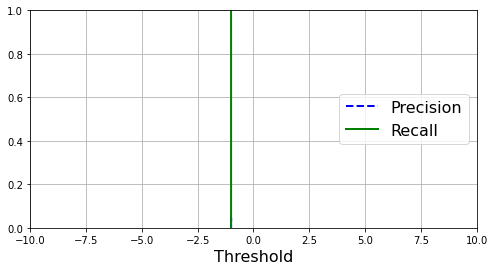

In [244]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [193]:
y_pred_cross_predict_poly_over = cross_val_predict(svc_poly_clf, X_train_over_prepared, y_train_over, cv=3)
y_pred_cross_decision_poly_over = cross_val_predict(svc_poly_clf, X_train_over_prepared, y_train_over, cv=3, method="decision_function")

In [256]:
precisions, recalls, thresholds = precision_recall_curve(y_train_over.astype(bool), y_pred_cross_decision_poly_over)

In [257]:
metrics(y_train_over, y_pred_cross_predict_poly_over)


Accuracy: 0.55
Precision: 0.55
Recall: 0.55
F1-score: 0.55

[[10885  8739]
 [ 8749 10875]]


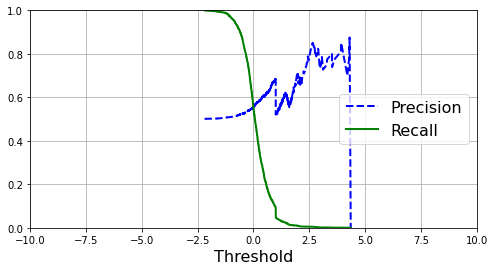

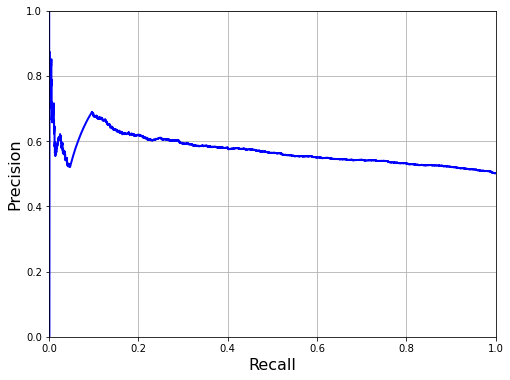

In [258]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plot_precision_vs_recall(precisions, recalls)

In [194]:
y_pred_cross_predict_poly_smote = cross_val_predict(svc_poly_clf, X_train_smote_prepared, y_train_smote, cv=3)
y_pred_cross_decision_poly_smote = cross_val_predict(svc_poly_clf, X_train_smote_prepared, y_train_smote, cv=3, method="decision_function")

In [264]:
precisions, recalls, thresholds = precision_recall_curve(y_train_smote.astype(bool), y_pred_cross_decision_poly_smote)

In [265]:
metrics(y_train_smote, y_pred_cross_predict_poly_smote)


Accuracy: 0.62
Precision: 0.59
Recall: 0.76
F1-score: 0.66

[[ 9224 10400]
 [ 4670 14954]]


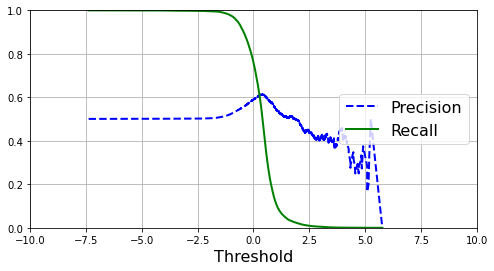

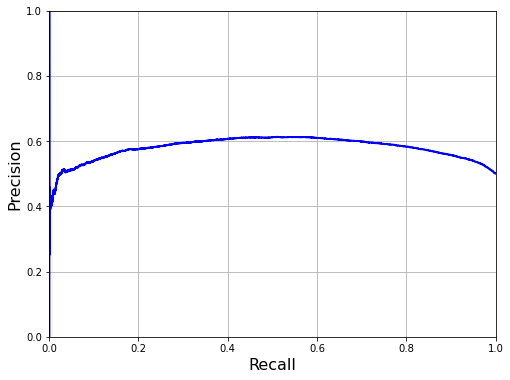

In [266]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plot_precision_vs_recall(precisions, recalls)

# rbf SVM

In [ ]:
svc_poly_clf.fit(X_train_over_prepared, y_train_over)
svc_rbf_clf.fit(X_train_over_prepared, y_train_over)

y_pred_svc_poly_clf = svc_poly_clf.predict(X_test_prepared)
y_pred_svc_rbf_clf = svc_rbf_clf.predict(X_test_prepared)

metrics(y_test, y_pred_svc_poly_clf)
metrics(y_test, y_pred_svc_rbf_clf)

In [267]:
y_pred_cross_predict_rbf = cross_val_predict(svc_rbf_clf, X_train_prepared, y_train, cv=3)
y_pred_cross_decision_rbf = cross_val_predict(svc_rbf_clf, X_train_prepared, y_train, cv=3, method="decision_function")

In [273]:
precisions, recalls, thresholds = precision_recall_curve(y_train.astype(bool), y_pred_cross_decision_rbf)

In [274]:
metrics(y_train, y_pred_cross_predict_rbf)


Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1-score: 0.00

[[19624     0]
 [  607     0]]


C:\Users\Alberto141\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


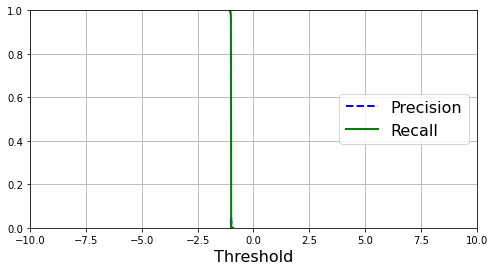

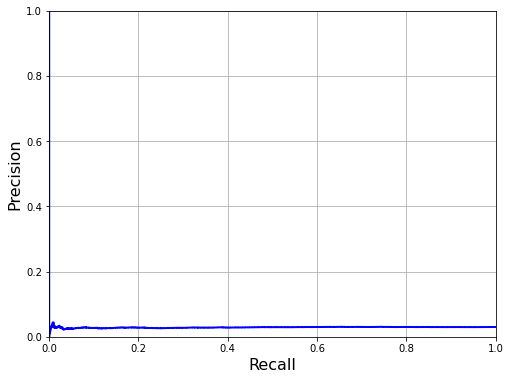

In [271]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plot_precision_vs_recall(precisions, recalls)

# Fine tune Poly SVM with smote data set

In [277]:
from sklearn.model_selection import GridSearchCV
svc = SVC(kernel="poly")
param_grid = [{'degree': [3, 2], 'C': [1, 2], 'coef0':[0, 1]}]

grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_smote_prepared, y_train_smote)

GridSearchCV(cv=3, estimator=SVC(kernel='poly'),
             param_grid=[{'C': [1, 2], 'coef0': [0, 1], 'degree': [3, 2]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [284]:
svc_best = grid_search.best_estimator_

In [281]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.6196518859411969 {'C': 1, 'coef0': 0, 'degree': 3}
0.6072960281936928 {'C': 1, 'coef0': 0, 'degree': 2}
0.5834813324867886 {'C': 1, 'coef0': 1, 'degree': 3}
0.6061201956289807 {'C': 1, 'coef0': 1, 'degree': 2}
0.6196518859411969 {'C': 2, 'coef0': 0, 'degree': 3}
0.6070862167008199 {'C': 2, 'coef0': 0, 'degree': 2}
0.5827385175431964 {'C': 2, 'coef0': 1, 'degree': 3}
0.6061622357520648 {'C': 2, 'coef0': 1, 'degree': 2}


In [286]:
y_pred_svc = svc_best.predict(X_test_prepared)
metrics(y_test, y_pred_svc)


Accuracy: 0.50
Precision: 0.03
Recall: 0.55
F1-score: 0.06

[[3246 3295]
 [  91  112]]


In [288]:
import joblib

joblib.dump(svc_best, 'svc_model.pkl')

['svc_model.pkl']

## Others

In [168]:
from sklearn.feature_selection import RFE

estimator=RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train_smote_prepared, y_train_smote)
selector.support_


selector.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  7,  5, 13, 10, 14, 16,  2, 15, 12, 11,
        1,  3,  1,  4,  1,  9,  8,  6])

In [185]:
from sklearn.feature_selection import RFECV

estimator=RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
selector = RFECV(estimator, step=1, cv=3)
selector = selector.fit(X_train_smote_prepared, y_train_smote)
selector.support_


selector.ranking_

array([ 3,  4,  2,  6,  5,  1,  7, 16, 14, 22, 19, 23, 25, 11, 24, 21, 20,
       10, 12,  9, 13,  8, 18, 17, 15])

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 20, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X_train_prepared)